<a href="https://colab.research.google.com/github/DrAlexSanz/Pix2Pix-DOTCSV/blob/master/Pix2Pix_DOTCSV.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This notebook is just for me, an implementation of the pix2pix algorithm following DotCSV's tutorial. It is very useful to get to know Tensorflow 2.0 and then I will use it for different things.

Video: [Video dotCSV](https://youtu.be/YsrMGcgfETY)

The tutorial, as he explains at the beginning, is based on this code:

[Tutorial Pix 2 Pix tensorflow 2.0](https://www.tensorflow.org/tutorials/generative/pix2pix)

In [1]:
%tensorflow_version 2.x
import tensorflow as tf
from tensorflow.keras.layers import *
from tensorflow.keras.models import Sequential, Model
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import os, shutil
import glob
from PIL import Image, ImageOps, ImageFilter

# Define paths

# Root

PATH = "/content/drive/My Drive/Pix2PixFlowers"

# Input path

INPATH = "/content/drive/My Drive/Pix2PixFlowers/InputFlowers"

# Sketch path

SKEPATH = "/content/drive/My Drive/Pix2PixFlowers/SketchFlowers"

# Output path

OUTPATH = "/content/drive/My Drive/Pix2PixFlowers/OutputFlowers"

# Checkpoints directory

CKPATH = "/content/drive/My Drive/Pix2PixFlowers/Checkpoints"

TensorFlow 2.x selected.


Activate drive to load the data

In [0]:
# !wget https://raw.githubusercontent.com/DrAlexSanz/Pix2Pix-DOTCSV/master/pix2pix.py
# from pix2pix import make_sketches

In [0]:
def make_sketches(path_in, path_sketch):
    
    """
    This takes one of the real images and creates the "blurred" or modified images
    path in is where the input images are, path sketch is the place where the modified ones will be stored.
    """
    
    os.chdir(path_in)
    file_list = glob.glob("*.jpg")
    file_list.sort()
#   os.chdir(path_sketch)

    for file in file_list:
        a = Image.open(file)
        a = a.filter(ImageFilter.GaussianBlur(radius = 2))
        a = a.filter(ImageFilter.GaussianBlur(radius = 4))
        a = a.filter(ImageFilter.GaussianBlur(radius = 10))
        a = a.filter(ImageFilter.BoxBlur(radius = 10))
        a = ImageOps.posterize(a, 4)
        b = np.asarray(a).copy() # Returns a view, not the array!! Need a copy to assign and play with it.
        b[b[:, :, 1] < 100] = 0
        im = Image.fromarray(np.uint8(b))
        os.chdir(path_sketch)
        im.save(file)
        os.chdir(path_in)
#         print(b.shape)
        
    return None

def resize(in_img, out_img, width, height):
    """
    Take an image and the target image, with height and width, and resize it.
    """
    
    inimg = tf.image.resize(in_img, [height, width])
    outimg = tf.image.resize(out_img, [height, width])
    
    return inimg, outimg
    
    

def normalize(in_img, out_img):
    """
    DotCSV does -1 to 1, I usually do 0 to 1. It doesn't have big implications and it is just a numerical stability issue
    In this case I put a lot of pixels to 0 with the green saturation, I risk that all my images become "flat"
    """
    
    inimg = (in_img / 127.5) - 1
    outimg = (out_img / 127.5) - 1
    
    return inimg, outimg
    
@tf.function()    
def random_jitter(in_img, out_img):
    """
    The paper advises to implement it. Also it's a data augmentation pipeline, can't hurt although this will increase running time
    
    """
    
    # first, resize
    inimage, outimage = resize(in_img, out_img, 286, 286) # Values from the paper
    
    # Stack, like this the crop will be the same (think physical stacking)
    stacked_img = tf.stack([inimage, outimage], axis = 0)
    cropped_img = tf.image.random_crop(stacked_img, size = [2, IMG_HEIGHT, IMG_WIDTH, 3])
    
    # Un-stack
    inimage = cropped_img[0]
    outimage = cropped_img[1]
    
    # Flip only if half of the times, randomly
    if tf.random.uniform(()) > 0.5:
        inimage = tf.image.flip_left_right(inimage)
        outimage = tf.image.flip_left_right(outimage)
        
    return inimage, outimage
    
    
def load_image(filename, augment):
    """
    Read one image and augment (or not)
    """
    # Read jpg, make it float just in case, and the [] at the end, take whatever dimensions, but only 3 channels. If it's png it has 4 and jpeg will decode it anyway.
    inimage = tf.cast(tf.image.decode_jpeg(tf.io.read_file(INPATH + "/" + filename)), tf.float32)[..., :3]
    skeimage = tf.cast(tf.image.decode_jpeg(tf.io.read_file(SKEPATH + "/" + filename)), tf.float32)[..., :3]
    
    inimage, outimage = resize(inimage, skeimage, IMG_HEIGHT, IMG_WIDTH)
    
    if augment == True:
        inimage, outimage = random_jitter(inimage, outimage)
    
    inimage, outimage = normalize(inimage, outimage)
    
    return inimage, outimage
    

def load_train_image(filename):
    return load_image(filename, augment = True)
    
def load_test_image(filename):
    return load_image(filename, augment = False)

In [3]:
from google.colab import drive
drive.mount('/content/drive', force_remount = True)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


(-0.5, 590.5, 499.5, -0.5)

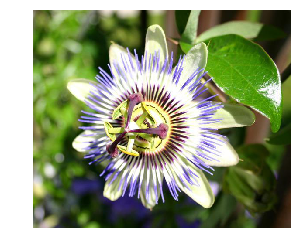

In [4]:
a = INPATH + "/image_00001.jpg"
a = mpimg.imread(a)
plt.imshow(a)
plt.axis("off")

In [0]:
make_sketches(INPATH, SKEPATH) #Call if ever needed

(-0.5, 666.5, 499.5, -0.5)

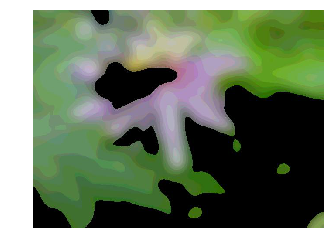

In [6]:
a = SKEPATH + "/image_00019.jpg"
a = mpimg.imread(a)
plt.imshow(a)
plt.axis("off")

Now that everything is loaded correctly, let's make a train/test split list of names.

In [0]:
imgurls = !ls -1 "{INPATH}"

n = 500
train_n = round(n * 0.8)

# Make a random list, the flowers were somehow sorted

randurls = np.copy(imgurls)

np.random.seed(13)

np.random.shuffle(randurls) # Don't save it!

# Split

trurls = randurls[:train_n]
testurls = randurls[train_n:n]


Now I only have a list. Then I will have to actually load the images.

In [0]:
IMG_HEIGHT = 256
IMG_WIDTH = 256

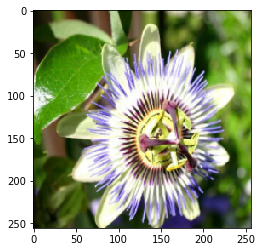

In [10]:
plt.imshow(((load_train_image(randurls[0])[0]) + 1) / 2)

In [9]:
train_dataset = tf.data.Dataset.from_tensor_slices(trurls) #specify which images I will load
train_dataset = train_dataset.map(load_train_image, num_parallel_calls = tf.data.experimental.AUTOTUNE) # Now I map to really load the image
# Last argument lets tensorflow decide how many // calls to use.

train_dataset = train_dataset.batch(1) # Automatic batch size! Paper says 1, but I can do other sizes.

#TEST

test_dataset = tf.data.Dataset.from_tensor_slices(testurls) #specify which images I will load
test_dataset = test_dataset.map(load_test_image, num_parallel_calls = tf.data.experimental.AUTOTUNE) # Now I map to really load the image
# Last argument lets tensorflow decide how many // calls to use.

test_dataset = test_dataset.batch(1)
train_dataset
# for checking

# train_dataset.take(1)

# for inimg, tgimg in train_dataset.take(5):
#     plt.imshow((inimg[0, ...] + 1) / 2)
#     plt.show()


<BatchDataset shapes: ((None, 256, 256, 3), (None, 256, 256, 3)), types: (tf.float32, tf.float32)>

In [0]:
# Define the encoding basic block

def downsample_block(filters, apply_batchnorm = True):
  """
  This function implements the basic CONV + BN + RELU block of the encoder. Downsample by a factor of 2.
  """
  initializer = tf.random_normal_initializer(0, 0.02)
  
  result = Sequential()
  
  # Conv2D
  result.add(Conv2D(filters,
                    kernel_size = 4,
                    strides = 2, 
                    padding = "same", 
                    kernel_initializer = initializer,
                    use_bias = not apply_batchnorm))
  
  # BatchNorm
  if apply_batchnorm:
      result.add(BatchNormalization())
  
  result.add(LeakyReLU())
  
  return result


# downsample_block(64)

In [0]:
def upsample_block(filters, apply_dropout = True):
  """
  This function implements the basic CONV + BN + RELU block of the encoder. Downsample by a factor of 2.
  """
  initializer = tf.random_normal_initializer(0, 0.02)
  
  result = Sequential()
  
  # Conv2D
  result.add(Conv2DTranspose(filters,
                             kernel_size = 4,
                             strides = 2, 
                             padding = "same", 
                             kernel_initializer = initializer,
                             use_bias = False))
  
  # BatchNorm
  result.add(BatchNormalization())
  
  # Dropout
  if apply_dropout == True:
    result.add(Dropout(0.5))
  
  result.add(ReLU())
  
  return result

# upsample_block(64)

I have the basic block of the UNET (Generator). Let's connect all.

In [0]:
def Generator():
  
    # Inputs
    
    inputs = tf.keras.layers.Input(shape = [None, None, 3])
    
    # Downsample side
    
    down_stack = [
        downsample_block(64, apply_batchnorm = False), # (batch_size, 128, 128, 64)
        downsample_block(128), # (batch_size, 64, 64, 128)
        downsample_block(256), # (batch_size, 32, 32, 256)
        downsample_block(512), # (batch_size, 16, 16, 512)
        downsample_block(512), # (batch_size, 8, 8, 512)
        downsample_block(512), # (batch_size, 4, 4, 512)
        downsample_block(512), # (batch_size, 2, 2, 512)
        downsample_block(512)] # (batch_size, 1, 1, 512)
    
    # Upsample side
    
    up_stack = [
        upsample_block(512, apply_dropout = True), # (batch_size, 2, 2, 512)
        upsample_block(512, apply_dropout = True), # (batch_size, 4, 4, 512)
        upsample_block(512, apply_dropout = True), # (batch_size, 8, 8, 512)
        upsample_block(512),                       # (batch_size, 16, 16, 512)
        upsample_block(256),                       # (batch_size, 32, 32, 256)
        upsample_block(128),                       # (batch_size, 64, 64, 128)
        upsample_block(64)]                        # (batch_size, 128, 128, 64)
    
    
    # Last layer. Generates the image I want to see
    
    initializer = tf.random_normal_initializer(0, 0.02)
    last = Conv2DTranspose(filters = 3,
                          kernel_size = 4,
                          padding = "same",
                          strides = 2,
                          kernel_initializer = initializer,
                          activation = "tanh") # Images are in +/-1 range
    
    # Now connect the layers, one layer to the next.
    
    x = inputs
    
    s = [] # For skip connections
    
    for down in down_stack:
        x = down(x)
        s.append(x)
    
    s = reversed(s[: -1])
    
    for up, skip in zip(up_stack, s):
        x = up(x)
        x = Concatenate()([x, skip])
        
    
    last_layer = last(x)
    
    return Model(inputs = inputs, outputs = last_layer)
  
generator = Generator()

The generator works, so I just need to create the discriminator. In the paper they don't use a CNN which produces a scalar, they use the patchGAN architecture. See below.

In [0]:
# train_dataset.take(1)


# for inimg, tgimg in train_dataset.take(1):
#     inimg = ((inimg[0, ...] + 1) / 2)

# gen_output = generator(((inimg + 1) * 255), training = False)

# plt.imshow(gen_output[0, ...])

The patchGan is a piecewise discriminator. Instead of outputting a 0 or 1, it outputs some values for some patches.

In [0]:
def Discriminator():
  
  ini = Input(shape=[None, None, 3], name = "input_img")
  gen = Input(shape=[None, None, 3], name = "gen_img")
  
  con = Concatenate()([ini, gen]) #(batch_size, 256, 256, 2*3!!!!) I'm concatenating
  
  initializer = tf.random_normal_initializer(0, 0.02)
  
  down_1 = downsample_block(64, apply_batchnorm = False)(con)
  down_2 = downsample_block(128)(down_1)
  down_3 = downsample_block(256)(down_2)
  down_4 = downsample_block(512)(down_3)
  
  last_layer = Conv2D(filters = 1,
                      kernel_size = 4,
                      strides = 1,
                      kernel_initializer = initializer,
                      padding = "same")(down_4)
  
  return Model(inputs = [ini, gen], outputs = last_layer)

discriminator = Discriminator()

# disc_out = discriminator([((inimg + 1) * 255), gen_output], training = False)

# plt.imshow(disc_out[0, ..., -1], vmin = -20, vmax = 20, cmap = "RdBu_r")
# plt.colorbar()
# disc_out.shape
                
  

As explained in the paper. The blue areas are the ones that the discriminator thinks that they are "less real". The less fake patches are the red ones. Should be like this because it's not trained.

Now I have to define the generator loss.

In [0]:
loss_object = tf.keras.losses.BinaryCrossentropy(from_logits = True) # Logits --> Sigmoid

In [0]:
def discriminator_loss(disc_real_output, disc_generated_output):
  
  real_loss = loss_object(tf.ones_like(disc_real_output), disc_real_output) # If my real values are close to the real output, the loss is low

  generated_loss = loss_object(tf.zeros_like(disc_real_output), disc_real_output) # If my generated image is close to the ground truth, the loss is low.
  
  total_disc_loss = real_loss + generated_loss # I can add weights here.
  
  return total_disc_loss

In [0]:
LAMBDA = 100

def generator_loss(disc_generated_output, gen_output, target):
    
    
    
    gen_loss = loss_object(tf.ones_like(disc_generated_output), disc_generated_output)
    
    l1_loss = tf.reduce_mean(tf.abs(target - gen_output))
    
    total_gen_loss = gen_loss + LAMBDA * l1_loss
    
    return total_gen_loss

Now do the logistics, the optimizer and checkpoint path.

In [18]:
generator_optimizer = tf.optimizers.Adam(2e-4, beta_1 = 0.5)
discriminator_optimizer = tf.optimizers.Adam(2e-4, beta_1 = 0.5)

checkpoint_prefix = os.path.join(CKPATH, "ckpt")

checkpoint = tf.train.Checkpoint(generator_optimizer = generator_optimizer,
                                 discriminator_optimizer = discriminator_optimizer,
                                 generator = generator,
                                 discriminator = discriminator)

checkpoint.restore(tf.train.latest_checkpoint(CKPATH)).assert_consumed()

AssertionError: ignored

In [0]:
def generate_images(model, test_input, tar, save_filename = False, display_imgs = True):
    """
    This function generates images to see the training process    
    
    """
    prediction = model(test_input, training = True)
    
    if save_filename == True:
        tf.keras.preprocessing.image.save_image(OUTPATH + save_filename + ".jpg", prediction[0, ...])
        
    plt.figure(figsize = (10, 10))
    
    display_list = [test_input[0], tar[0], prediction[0]]
    title = ["Input image", "Target image", "Generated Image"]
    
    if display_imgs == True:
        for i in range(3):
            plt.subplot(1, 3, i + 1)
            plt.title(title[i])
            plt.imshow(display_list[i] * 0.5 + 0.5)
            plt.axis("off")
            
    plt.show()
    
    return None

In [0]:
@tf.function()
def train_step(input_img, target):
    """
    One step of training
    """
    
    with tf.GradientTape() as gen_tape, tf.GradientTape() as discr_tape:
    
        output_image = generator(input_img, training = True)

        output_gen_discr = discriminator([output_image, input_img], training = True)
        output_trg_discr = discriminator([target, input_img], training = True)

        discr_loss = discriminator_loss(output_trg_discr, output_gen_discr)
        gen_loss = generator_loss(output_gen_discr, output_image, target)
        
        generator_grads = gen_tape.gradient(gen_loss, generator.trainable_variables)
        discriminator_grads = discr_tape.gradient(discr_loss, discriminator.trainable_variables)
        
        generator_optimizer.apply_gradients(zip(generator_grads, generator.trainable_variables))
        discriminator_optimizer.apply_gradients(zip(discriminator_grads, discriminator.trainable_variables))

In [0]:
from IPython.display import clear_output

def train(dataset, epochs):
    """
    This is the train function. Takes dataset and runs for n iterations
    
    """
    
    for n in range(epochs):
        img_i = 0
        
        for input_image, target in dataset:
            train_step(input_image, target)
            if img_i % 50 == 0:
                print("Epoch " + str(n) + " train: " + str(img_i) + "/" + str(len(trurls)))
            img_i = img_i + 1
            
            clear_output(wait = True)
        
        img_i = 0
        for inp, tar in test_dataset.take(5):
            generate_images(generator, inp, tar, str(img_i) + "_" + str(n), display_imgs = True)
            img_1 = img_i + 1
        # Save model every 25 epochs
        
        if (n + 1) % 25 == 0:
            checkpoint.save(file_prefix = checkpoint_prefix)

In [0]:
train(train_dataset, epochs = 250)

Epoch 2 train: 250/400
